**Data Preprocessing**

In [31]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import json
import albumentations as A

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#!unzip /content/drive/MyDrive/rgb.zip
#!unzip /content/drive/MyDrive/labels.zip

In [34]:
# prepare annotations
image_path = "/content/rgb"
annotation_path = "/content/labels"
image_list = os.listdir(image_path)

annotations = []
for file in os.listdir(annotation_path)[0:10000]:
  with open(os.path.join(annotation_path, file)) as f:
    d = json.load(f)
    if file.replace(".json", ".png") in image_list:
      annotations.append({
          "img": file.replace(".json", ".png"),
          "landmarks": [x for x in d['keypoints'].values()]}
      )

In [50]:
class Shoe3DLandmarkDataset(tf.keras.utils.Sequence):
    def __init__(self, image_dir, annotations, batch_size=32, augment=False):
        self.image_dir = image_dir
        self.annotations = annotations
        self.batch_size = batch_size
        self.augment = augment
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])

    def __len__(self):
        return int(np.ceil(len(self.annotations) / self.batch_size))

    def __getitem__(self, idx):
        batch_anns = self.annotations[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, landmarks = [], []

        for ann in batch_anns:
            img_path = os.path.join(self.image_dir, ann['img'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            transformed = self.transform(image=img)
            crop = transformed["image"]
            images.append(crop)
            landmarks.append(np.divide(np.array(ann['landmarks']), np.array([w, h])).flatten())

        return np.array(images), np.array(landmarks)


**Build Model**

In [51]:
def build_model(num_landmarks=15):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet',
        pooling='avg'
    )

    x = base_model.output
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_landmarks * 2)(x)  # x, y, z per point

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model

**Training setup**

In [53]:
def compile_and_train(model, train_gen, val_gen, epochs=10):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='mse',
        metrics=['mae']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
    ]

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    return model

In [54]:
# Split and create data generators
train_anns, val_anns = train_test_split(annotations, test_size=0.2)
train_gen = Shoe3DLandmarkDataset("rgb/", train_anns, batch_size=16)
val_gen = Shoe3DLandmarkDataset("rgb/", val_anns, batch_size=16)
# Train
model = build_model(num_landmarks=8)
model = compile_and_train(model, train_gen, val_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 0.1251 - mae: 0.2242

466/466 ━━━━━━━━━━━━━━━━━━━━ 319s 548ms/step - loss: 0.1249 - mae: 0.2241 - val_loss: 0.0848 - val_mae: 0.2194
Epoch 2/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.0088 - mae: 0.0741

466/466 ━━━━━━━━━━━━━━━━━━━━ 225s 483ms/step - loss: 0.0088 - mae: 0.0741 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 3/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.0056 - mae: 0.0590

466/466 ━━━━━━━━━━━━━━━━━━━━ 219s 470ms/step - loss: 0.0056 - mae: 0.0590 - val_loss: 0.0012 - val_mae: 0.0273
Epoch 4/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0042 - mae: 0.0511

466/466 ━━━━━━━━━━━━━━━━━━━━ 221s 473ms/step - loss: 0.0042 - mae: 0.0511 - val_loss: 7.4917e-04 - val_mae: 0.0212
Epoch 5/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.0033 - mae: 0.0450

466/466 ━━━━━━━━━━━━━━━━━━━━ 217s 467ms/step - loss: 0.0033 - mae: 0.0450 - val_loss: 5.4812e-04 - val_mae: 0.0181
Epoch 6/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.0027 - mae: 0.0405

466/466 ━━━━━━━━━━━━━━━━━━━━ 217s 466ms/step - loss: 0.0027 - mae: 0.0405 - val_loss: 4.5724e-04 - val_mae: 0.0167
Epoch 7/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0024 - mae: 0.0383

466/466 ━━━━━━━━━━━━━━━━━━━━ 223s 479ms/step - loss: 0.0024 - mae: 0.0383 - val_loss: 4.4463e-04 - val_mae: 0.0163
Epoch 8/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.0020 - mae: 0.0349

466/466 ━━━━━━━━━━━━━━━━━━━━ 215s 461ms/step - loss: 0.0020 - mae: 0.0349 - val_loss: 3.8418e-04 - val_mae: 0.0148
Epoch 9/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 207s 445ms/step - loss: 0.0018 - mae: 0.0328 - val_loss: 7.6852e-04 - val_mae: 0.0226
Epoch 10/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 0.0016 - mae: 0.0310

466/466 ━━━━━━━━━━━━━━━━━━━━ 223s 477ms/step - loss: 0.0016 - mae: 0.0310 - val_loss: 3.0667e-04 - val_mae: 0.0135


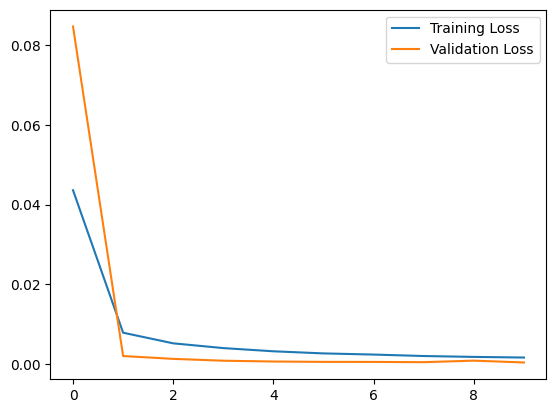

In [66]:
import matplotlib.pyplot as plt
plt.plot(model.history.history["loss"], label="Training Loss")
plt.plot(model.history.history["val_loss"], label="Validation Loss")
plt.legend()

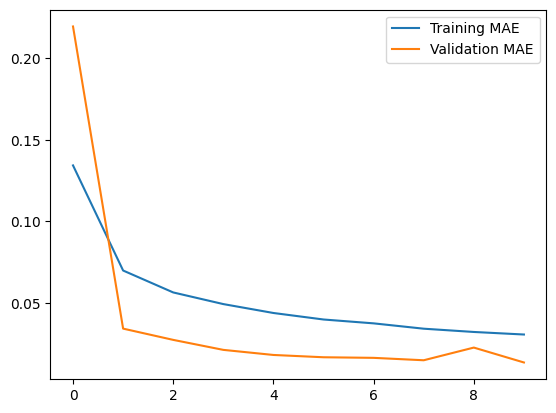

In [68]:
import matplotlib.pyplot as plt
plt.plot(model.history.history["mae"], label="Training MAE")
plt.plot(model.history.history["val_mae"], label="Validation MAE")
plt.legend()

In [71]:
tf.saved_model.save(model, "detection_model_saved")

In [72]:
!zip -r detection_model_saved.zip detection_model_saved

  adding: detection_model_saved/ (stored 0%)
  adding: detection_model_saved/saved_model.pb (deflated 91%)
  adding: detection_model_saved/fingerprint.pb (stored 0%)
  adding: detection_model_saved/assets/ (stored 0%)
  adding: detection_model_saved/variables/ (stored 0%)
  adding: detection_model_saved/variables/variables.index (deflated 80%)
  adding: detection_model_saved/variables/variables.data-00000-of-00001 (deflated 9%)


In [73]:
model.save("detection_model.keras")

**Evaluation**

In [112]:
image_path = "/content/IMG_3543.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (224,224))
resized_image = resized_image/255
resized_image = np.expand_dims(resized_image, axis=0)
detection = model.predict(resized_image)[0]
detection

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([0.5764173 , 0.15728882, 0.4239149 , 0.14544486, 0.43141   ,
       0.22180128, 0.33507702, 0.2843441 , 0.29212347, 0.35841298,
       0.50631535, 0.93135566, 0.28611606, 0.41446403, 0.6452942 ,
       0.3571151 ], dtype=float32)

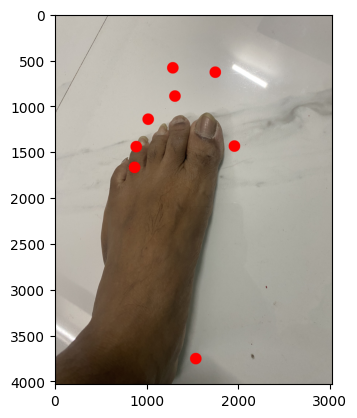

In [113]:
h, w, _ = image.shape
i = 0
image_copy = image.copy()
while i< len(detection):
  x = int(detection[i] * w)
  y = int(detection[i+1] * h)
  cv2.circle(image_copy, (x, y), 63, (255,0,0), -1)
  i += 2
plt.imshow(image_copy)

In [102]:
image.shape

(4032, 3024, 3)